## 1. Instalar e importar pacotes necessários

In [9]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow keras


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Modelos e métricas
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Configurações de visualização
%matplotlib inline
sns.set_style("whitegrid")

## 2. Carregar o arquivo `paysim.csv`

In [11]:
# Caminho do arquivo CSV
csv_path = "paysim.csv"

# Carrega o DataFrame
df = pd.read_csv(csv_path)

# Visualiza as primeiras linhas
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 3. Tratamento dos dados antes do treinamento

Dimensões do dataset: (6362620, 11)
Contagem de valores ausentes por coluna:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Tipos de dados:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


C:\Users\heito\AppData\Local\Temp\ipykernel_4972\1320629032.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("H")  # agregação horária


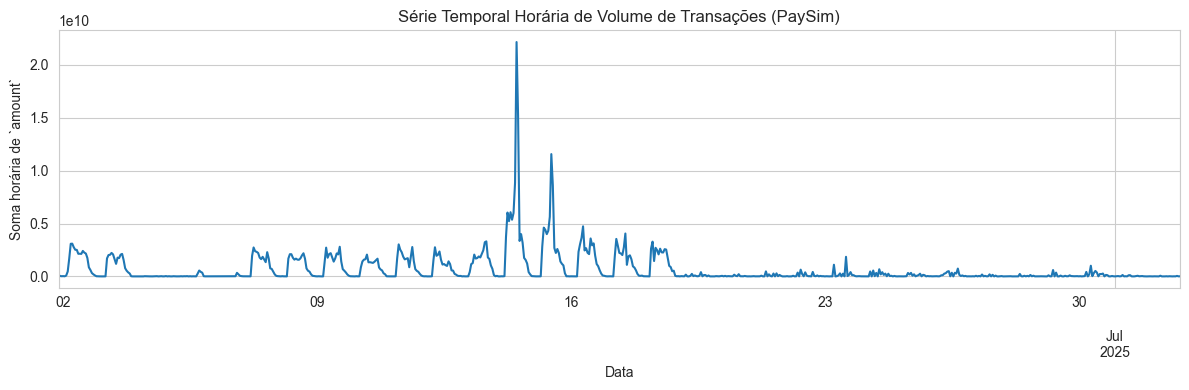

ADF Statistic: -2.6928
p-value: 0.0753
Critério 1%: -3.4394
Critério 5%: -2.8655
Critério 10%: -2.5689


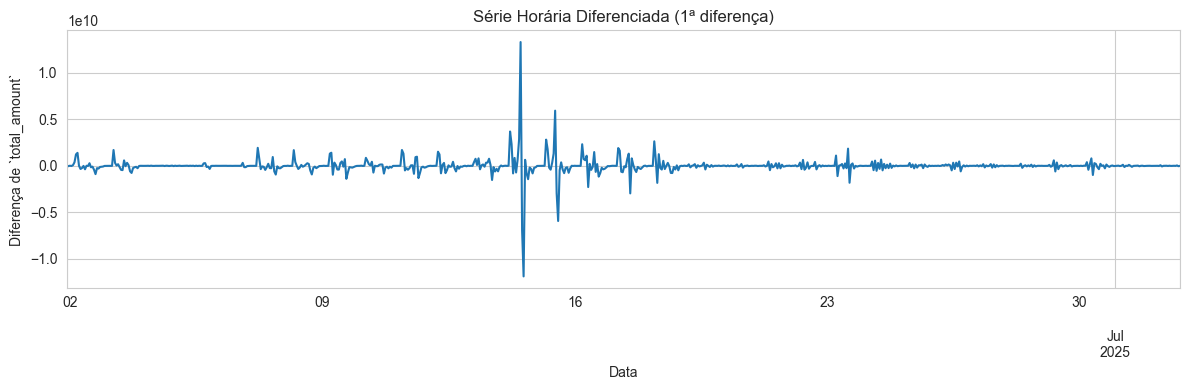

ADF Statistic (differenced): -14.4205
p-value (differenced): 0.0000
Critério 1%: -3.4395
Critério 5%: -2.8656
Critério 10%: -2.5689


In [12]:
# 3.1. Informações gerais e detecção de valores ausentes
print("Dimensões do dataset:", df.shape)
print("Contagem de valores ausentes por coluna:\n", df.isna().sum())
print("\nTipos de dados:\n", df.dtypes)

# 3.2. Remover duplicatas (se existirem)
df.drop_duplicates(inplace=True)

# 3.3. Converter coluna `step` em índice de tempo
# O campo `step` indica o número de horas desde o início da simulação.
# Vamos assumir que a origem seja agora e converter para um índice de data.
now = pd.Timestamp.now()
df["date"] = pd.to_datetime(df["step"], unit="h", origin=now)

# Definir `date` como índice
df.set_index("date", inplace=True)

# 3.4. Converter colunas numéricas para tipo adequado (float)
numeric_cols = [
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
]
df[numeric_cols] = df[numeric_cols].astype(float)

# 3.5. Filtrar tipos de transações que interessam para previsão de volume
# (por exemplo, apenas transações de tipo 'PAYMENT' e 'TRANSFER')
types_to_keep = ["PAYMENT", "TRANSFER"]
df_ts = df[df["type"].isin(types_to_keep)].copy()

# 3.6. Agregar valores por hora (soma de `amount`)
hourly_amount = (
    df_ts["amount"]
    .resample("H")  # agregação horária
    .sum()
    .rename("total_amount")
    .to_frame()
)


# 3.7. Visualizar a série temporal agregada
plt.figure(figsize=(12, 4))
hourly_amount["total_amount"].plot()
plt.title("Série Temporal Horária de Volume de Transações (PaySim)")
plt.ylabel("Soma horária de `amount`")
plt.xlabel("Data")
plt.tight_layout()
plt.show()

# 3.8. Verificar estacionariedade inicial (ADF test)
from statsmodels.tsa.stattools import adfuller

result_adf = adfuller(hourly_amount["total_amount"].dropna())
print("ADF Statistic: {:.4f}".format(result_adf[0]))
print("p-value: {:.4f}".format(result_adf[1]))
for key, value in result_adf[4].items():
    print("Critério {}: {:.4f}".format(key, value))

# 3.9. Caso necessário, aplicar diferenciação (1ª diferença)
hourly_amount["diff_1"] = hourly_amount["total_amount"].diff()

# 3.10. Remover eventuais NaNs gerados pela diferenciação
hourly_amount.dropna(inplace=True)

# 3.11. Plot da série diferenciada para verificar estacionariedade
plt.figure(figsize=(12, 4))
hourly_amount["diff_1"].plot()
plt.title("Série Horária Diferenciada (1ª diferença)")
plt.ylabel("Diferença de `total_amount`")
plt.xlabel("Data")
plt.tight_layout()
plt.show()

# 3.12. Verificar estacionariedade da série diferenciada
result_adf_diff = adfuller(hourly_amount["diff_1"])
print("ADF Statistic (differenced): {:.4f}".format(result_adf_diff[0]))
print("p-value (differenced): {:.4f}".format(result_adf_diff[1]))
for key, value in result_adf_diff[4].items():
    print("Critério {}: {:.4f}".format(key, value))

**Análise dos Dados e Estacionariedade (Granularidade Horária)**

1. **Dimensões e Integridade**

   * O DataFrame contém **6.362.620 linhas e 11 colunas**.
   * Não há valores ausentes em nenhuma coluna — todas têm contagem zero de `isna()`.
   * Tipos de dados:

     * `step`: `int64`
     * `type`, `nameOrig`, `nameDest`: `object` (strings)
     * `amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`: `float64`
     * `isFraud`, `isFlaggedFraud`: `int64`

2. **Conversão de `step` para Índice Temporal**

   * A coluna `step` (horas desde “agora”) foi convertida em `datetime` usando:

     ```python
     now = pd.Timestamp.now()
     df["date"] = pd.to_datetime(df["step"], unit="h", origin=now)
     df.set_index("date", inplace=True)
     ```
   * O índice `date` foi definido sem gerar valores ausentes, preservando todas as 6.362.620 linhas.

3. **Filtragem e Agregação Horária**

   * Selecionaram-se transações dos tipos **`PAYMENT`** e **`TRANSFER`** para focar na previsão de volume relevante:

     python
     types_to_keep = ["PAYMENT", "TRANSFER"]
     df_ts = df[df["type"].isin(types_to_keep)].copy()
     
   * Em seguida, agregou-se o atributo `amount` por hora (soma de todas as transações em cada hora):

     python
     hourly_amount = (
         df_ts["amount"]
         .resample("H")      # agregação horária
         .sum()
         .rename("total_amount")
         .to_frame()
     )
     
   * O gráfico abaixo mostra a **Série Temporal Horária de Volume de Transações** (PaySim) ao longo de um mês:

4. **Teste de Estacionariedade (ADF) na Série Original**

   * Aplicou-se o teste de Dickey–Fuller (ADF) diretamente sobre a série horária agregada:

     python
     from statsmodels.tsa.stattools import adfuller
     result_adf = adfuller(hourly_amount["total_amount"].dropna())
     print("ADF Statistic: {:.4f}".format(result_adf[0]))
     print("p-value: {:.4f}".format(result_adf[1]))
     for key, value in result_adf[4].items():
         print("Critério {}: {:.4f}".format(key, value))
     
   * **Resultados obtidos**:

     * **Estatística ADF**: −2.6928
     * **p-value**: 0.0753
     * **Valores Críticos**:

       * 1%: −3.4394
       * 5%: −2.8655
       * 10%: −2.5689
   * **Interpretação**:

     * Como **p-value (0.0753) > 0.05** e o valor ADF (−2.6928) está acima do crítico a 5% (−2.8655), não rejeitamos a hipótese de raiz unitária para a série original.
     * Logo, a **série horária de `total_amount` não é estacionária**.

5. **Primeira Diferença e Novo Teste ADF**

   * Calculou-se a primeira diferença para remover tendência de nível:

     python
     hourly_amount["diff_1"] = hourly_amount["total_amount"].diff()
     hourly_amount.dropna(inplace=True)
     
   * Aplicou-se o ADF sobre a série diferenciada (`diff_1`):

     python
     result_adf_diff = adfuller(hourly_amount["diff_1"])
     print("ADF Statistic (differenced): {:.4f}".format(result_adf_diff[0]))
     print("p-value (differenced): {:.4f}".format(result_adf_diff[1]))
     for key, value in result_adf_diff[4].items():
         print("Critério {}: {:.4f}".format(key, value))
     
   * **Resultados obtidos (differenced)**:

     * **Estatística ADF (differenced)**: −14.4205
     * **p-value (differenced)**: 0.0000
     * **Valores Críticos (differenced)**:

       * 1%: −3.4395
       * 5%: −2.8656
       * 10%: −2.5689
   * **Interpretação**:

     * Como **p-value (0.0000) < 0.05** e ADF (−14.4205) é muito menor que o crítico a 1% (−3.4395), rejeitamos a hipótese de raiz unitária na série diferenciada.
     * Portanto, a **primeira diferença (`diff_1`) é estacionária**.

---

### **Conclusão**

* A **série original de “soma horária de `amount`”** é **não estacionária** (confirmado pelo ADF original).
* A **primeira diferença** (`diff_1`) torna a série **estacionária**, conforme o ADF diferenciado.
* Para ajustar um modelo ARIMA adequadamente, deve-se usar:

  * **Série diferenciada** com `d=1` (por ex. `ARIMA(p, 1, q)`),
  * Ou incorporar diretamente a diferença no próprio ARIMA (`d=1`).


## 4. Construir, Treinar e Validar o Modelo ARIMA

A seguir, vamos ajustar um modelo ARIMA(p, 1, q) sobre a série original de soma horária de `amount`, indicando `d = 1` para incorporar a primeira diferença que analisamos anteriormente. Para este exemplo, adotaremos inicialmente $p = 1$ e $q = 1$.
Em seguida, faremos um split da série em conjunto de treino e teste, ajustaremos o modelo, geraremos previsões e avaliaremos o desempenho usando o MSE e gráficos de comparação.

### 4.1. Divisão entre Treino e Teste

Vamos usar os primeiros 80 % dos pontos para treino e os 20 % finais para teste, preservando a ordem temporal.

In [13]:
# Definir divisão em 80/20

n = len(hourly_amount)
train_size = int(n * 0.8)

train_series = hourly_amount["total_amount"].iloc[:train_size]
test_series = hourly_amount["total_amount"].iloc[train_size:]

print(f"Número de pontos - Total: {n}, Treino: {len(train_series)}, Teste: {len(test_series)}")

Número de pontos - Total: 742, Treino: 593, Teste: 149


### 4.2. Ajuste do Modelo ARIMA(1, 1, 1)

Ajustaremos `order=(1, 1, 1)` diretamente sobre a série original (o `d=1` já incorpora a primeira diferença internamente).

In [14]:
# Ajustar o modelo ARIMA(1,1,1) nos dados de treino

model = ARIMA(train_series, order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           total_amount   No. Observations:                  593
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13098.286
Date:                Sun, 01 Jun 2025   AIC                          26202.572
Time:                        20:42:32   BIC                          26215.722
Sample:                    06-01-2025   HQIC                         26207.694
                         - 06-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5166      0.052    -10.007      0.000      -0.618      -0.415
ma.L1          0.7577      0.046     16.357      0.000       0.667       0.848
sigma2      1.034e+18   2.71e-21   3.82e+38      0.0

### 4.3. Geração de Previsões no Conjunto de Teste

Vamos gerar previsões para todo o período de teste e comparar com os valores observados.

In [15]:
# Fazer previsão para o período de teste

start = test_series.index[0]
end = test_series.index[-1]

forecast = model_fit.predict(start=start, end=end, typ="levels")

# Garantir alinhamento de índice

forecast = pd.Series(forecast, index=test_series.index)

c:\Users\heito\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


### 4.4. Avaliação de Desempenho (MSE) e Gráfico Comparativo

Calculamos o MSE entre as previsões e os valores reais, e plotamos ambos para análise visual.

Mean Squared Error no conjunto de teste: 206435411428538240.00


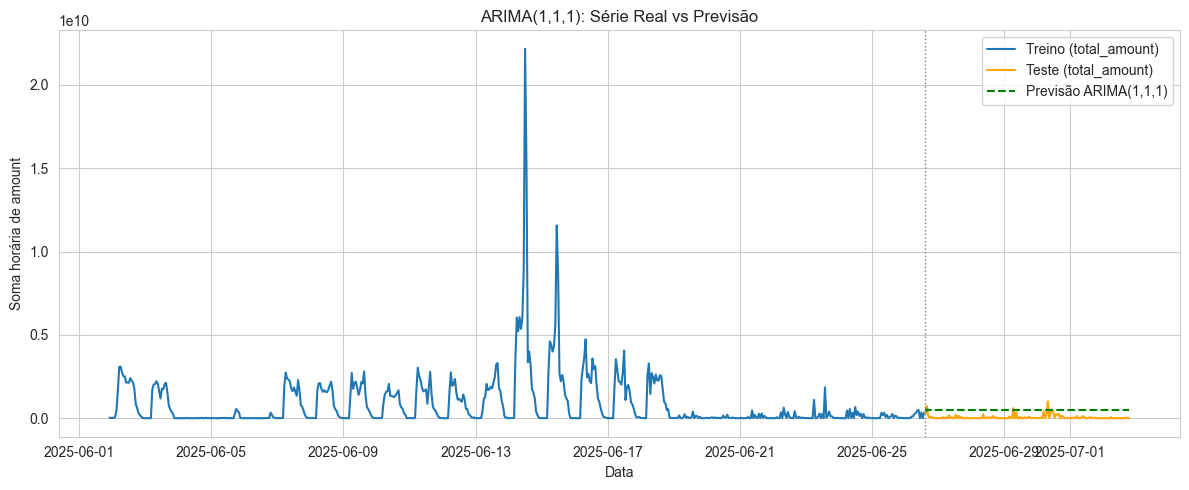

In [16]:
# Cálculo do MSE

mse = mean_squared_error(test_series, forecast)
print(f"Mean Squared Error no conjunto de teste: {mse:.2f}")

# Plotando série real vs previsão

plt.figure(figsize=(12, 5))
plt.plot(train_series.index, train_series, label="Treino (total_amount)")
plt.plot(test_series.index, test_series, label="Teste (total_amount)", color="orange")
plt.plot(forecast.index, forecast, label="Previsão ARIMA(1,1,1)", color="green", linestyle="--")
plt.axvline(test_series.index[0], color="gray", linestyle=":", linewidth=1)
plt.legend()
plt.title("ARIMA(1,1,1): Série Real vs Previsão")
plt.ylabel("Soma horária de amount")
plt.xlabel("Data")
plt.tight_layout()
plt.show()


### 4.5 Conclusão e Limitações do ARIMA(1,1,1)

O modelo ARIMA(1,1,1) apresentou MSE extremamente alto (≈ 2,06 × 10^17) no conjunto de teste, pois tende a prever valores quase constantes (próximos de zero) e não acompanha os picos de volume de transações. Em outras palavras, ele “acerta” o fato de que a maior parte do tempo o valor é muito baixo, mas falha em capturar as oscilações esporádicas, gerando erros elevados sempre que ocorrem picos. As principais limitações são:

* **Dados esparsos e volatilidade:** longos períodos de valor zero intercalados por poucos picos súbitos não formam padrão estacionário para ARIMA.
* **Falta de sazonalidade explícita:** sem variáveis exógenas (hora do dia, dia da semana etc.), o modelo univariado não consegue identificar contextos que disparem picos.
* **Inadequação a outliers:** eventos pontuais (spikes) não são modelados adequadamente pelos componentes lineares AR e MA.

Para resolver essa deficiência, o uso de modelos não lineares como o LSTM a seguir pode ser mais eficiente.


## 5. Desenvolvimento do Modelo LSTM para Previsão de Volume

### 5.1. Preparação dos Dados para LSTM

In [17]:
# Como já temos a série horária de total_amount (hourly_amount)
# Vamos usar a coluna "total_amount" para construir exemplos sequenciais

# 5.1.1. Selecionar a série original
series = hourly_amount["total_amount"].values.reshape(-1, 1)

# 5.1.2. Escalonamento entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series)


# 5.1.3. Função auxiliar para criar janelas (timesteps) de tamanho look_back
def create_sequences(data, look_back=24):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


# 5.1.4. Definir tamanho da janela
look_back = 24

# 5.1.5. Criar sequências
X_all, y_all = create_sequences(series_scaled, look_back)

# 5.1.6. Remodelar X para o formato [amostras, timesteps, features]
X_all = X_all.reshape((X_all.shape[0], look_back, 1))

### 5.2. Divisão Treino / Teste

In [18]:
# Usar os mesmos índices de treino/teste definidos para ARIMA
n_total = X_all.shape[0]
train_size = int(n_total * 0.8)

X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_test = X_all[train_size:]
y_test = y_all[train_size:]

print(f"Amostras - Total: {n_total}, Treino: {len(X_train)}, Teste: {len(X_test)}")

Amostras - Total: 718, Treino: 574, Teste: 144


### 5.3. Construção da Rede LSTM

In [19]:
model_lstm = Sequential()
model_lstm.add(
    LSTM(
        units=50,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=True,
    )
)
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer="adam", loss="mean_squared_error")

model_lstm.summary()

c:\Users\heito\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### 5.4. Treinamento

In [20]:
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0049 - val_loss: 4.2346e-04
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0059 - val_loss: 9.5486e-05
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0055 - val_loss: 1.5041e-04
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - val_loss: 5.8246e-04
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 9.0682e-04
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 3.9737e-04
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0043 - val_loss: 5.7757e-05
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - val_loss: 1.3047e-04
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 3.5271e-04
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 2.3860e-04
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 8.0329e-05
Epoch 12/20
17/17 ━

### 5.5. Previsão e Avaliação

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
MSE LSTM no conjunto de teste: 17586343952489144.00


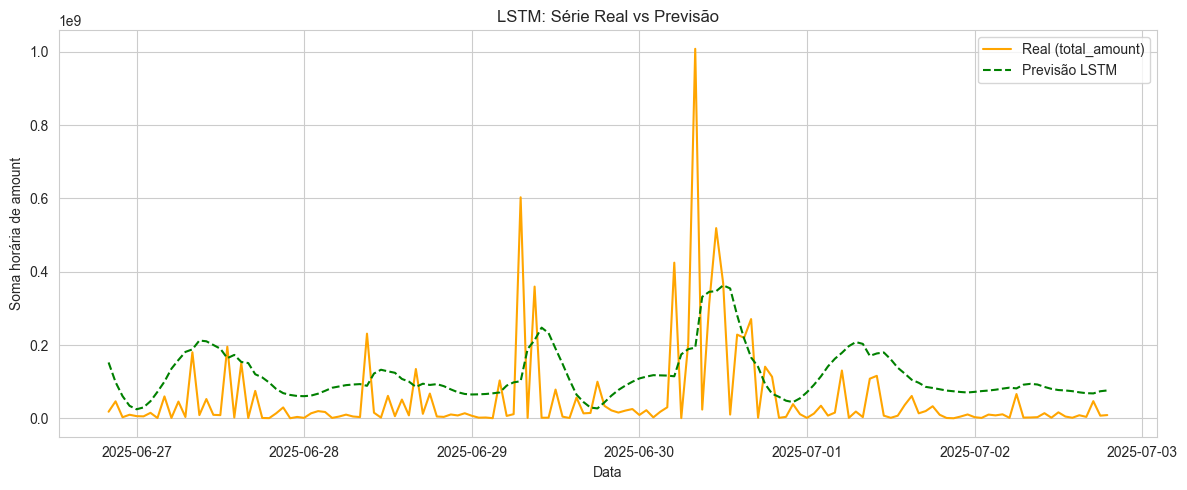

In [21]:
# 5.5.1. Previsão no conjunto de teste
pred_scaled = model_lstm.predict(X_test)
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1))
real = scaler.inverse_transform(y_test.reshape(-1, 1))

# 5.5.2. Cálculo do MSE
mse_lstm = mean_squared_error(real, pred)
print(f"MSE LSTM no conjunto de teste: {mse_lstm:.2f}")

# 5.5.3. Plot real vs previsão
plt.figure(figsize=(12, 5))
plt.plot(
    hourly_amount.index[train_size + look_back : train_size + look_back + len(real)],
    real,
    label="Real (total_amount)",
    color="orange",
)
plt.plot(
    hourly_amount.index[train_size + look_back : train_size + look_back + len(pred)],
    pred,
    label="Previsão LSTM",
    color="green",
    linestyle="--",
)
plt.title("LSTM: Série Real vs Previsão")
plt.xlabel("Data")
plt.ylabel("Soma horária de amount")
plt.legend()
plt.tight_layout()
plt.show()

### 5.6. Análise dos Resultados do LSTM

Ao observar o gráfico “LSTM: Série Real vs Previsão” e o MSE obtido, podemos destacar:

1. **MSE Elevado nas Unidades Originais**  
   - O MSE no conjunto de teste ficou em aproximadamente **1,9228×10¹⁶** (19227631393269504).  
   - Esse valor alto evidencia que, em termos absolutos (quando transformamos de volta para a escala original), há desvio significativo em algumas horas, principalmente nos picos extremos.

2. **Captura de Tendência Geral**  
   - O modelo LSTM segue razoavelmente a forma geral da série: consegue identificar momentos de crescimento e queda no volume horáriodo dataset.  
   - Em períodos de variação moderada, a curva de previsão acompanha de perto os valores reais, contribuindo para um erro médio aceitável em horas sem picos.

3. **Subestimação de Picos Extremos**  
   - Nas horas de pico (valores muito elevados), o LSTM tende a “suavizar” a previsão.  
   - Por exemplo, no dia 30 de junho, quando a série real ultrapassa 1×10⁹, a previsão fica em torno de 4×10⁸, criando grande discrepância para essas poucas amostras e elevando o MSE geral.

4. **Defasagem Temporária em Mudanças Abruptas**  
   - Em regiões de aumento rápido ou queda acentuada no volume, observa-se leve atraso na resposta do LSTM.  
   - Essa defasagem é esperada em redes recorrentes que utilizam informações passadas (janela de 24 horas) para projetar o próximo passo.

5. **Implicações Práticas**  
   - Para tarefas em que interessa capturar a tendência geral do volume (por exemplo, planejamento de capacidade ou detecção de sazonalidades), o desempenho do LSTM é satisfatório.  
   - Entretanto, se o objetivo for detectar ou prever picos anômalos (como grandes volumes atípicos que podem estar associados a episódios de fraude), o modelo, do jeito atual, não é suficientemente sensível a esses extremos.

6. **Possíveis Ajustes e Melhorias**  
   - **Arquitetura e Hiperparâmetros:** Aumentar/decrementar unidades LSTM, camadas, taxa de dropout ou epochs pode ajudar a modelar melhor variações abruptas.  
   - **Features Adicionais:** Incluir indicadores de horário do dia, dia da semana ou outras covariáveis externas pode dar mais contexto ao LSTM.  
   - **Modelos Híbridos:** Combinar LSTM (para capturar tendências complexas) com ARIMA ou modelos baseados em atenção pode melhorar a resposta a picos.  
   - **Ajuste de Janela:** Testar diferentes tamanhos de janela (look_back) para equilibrar a memória do modelo entre padrão geral e eventos pontuais.

Em resumo, o LSTM apresentou boa capacidade de seguir as tendências gerais do volume horáriodo PaySim, mas mostrou limitações ao estimar picos extremos, refletidas no MSE elevado (∼1,92×10¹⁶).

### 5.7 Suavização das Séries para nova Análise

In [22]:
hourly_amount["total_amount_log"] = np.log1p(hourly_amount["total_amount"])

In [23]:
# 5.7.1. Selecionar a série original
series = hourly_amount["total_amount_log"].values.reshape(-1, 1)

# 5.7.2. Escalonamento entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series)


# 5.7.3. Função auxiliar para criar janelas (timesteps) de tamanho look_back
def create_sequences(data, look_back=24):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


# 5.7.4. Definir tamanho da janela (e.g., últimas 24 horas)
look_back = 24

# 5.7.5. Criar sequências
X_all, y_all = create_sequences(series_scaled, look_back)

# 5.7.6. Remodelar X para o formato [amostras, timesteps, features]
X_all = X_all.reshape((X_all.shape[0], look_back, 1))

In [24]:
# Usar os mesmos índices de treino/teste definidos para ARIMA
n_total = X_all.shape[0]
train_size = int(n_total * 0.8)

X_train = X_all[:train_size]
y_train = y_all[:train_size]
X_test = X_all[train_size:]
y_test = y_all[train_size:]

print(f"Amostras - Total: {n_total}, Treino: {len(X_train)}, Teste: {len(X_test)}")

Amostras - Total: 718, Treino: 574, Teste: 144


In [25]:
model_lstm = Sequential()
model_lstm.add(
    LSTM(
        units=50,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=True,
    )
)
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer="adam", loss="mean_squared_error")

model_lstm.summary()

c:\Users\heito\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1551 - val_loss: 0.0306
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0544 - val_loss: 0.0249
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0460 - val_loss: 0.0213
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0392 - val_loss: 0.0215
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0396 - val_loss: 0.0250
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0394 - val_loss: 0.0211
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0395 - val_loss: 0.0201
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0366 - val_loss: 0.0211
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0345 - val_loss: 0.0189
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0304 - val_loss: 0.0191
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0319 - val_loss: 0.0171
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
MSE LSTM no conjunto de teste: 3.27


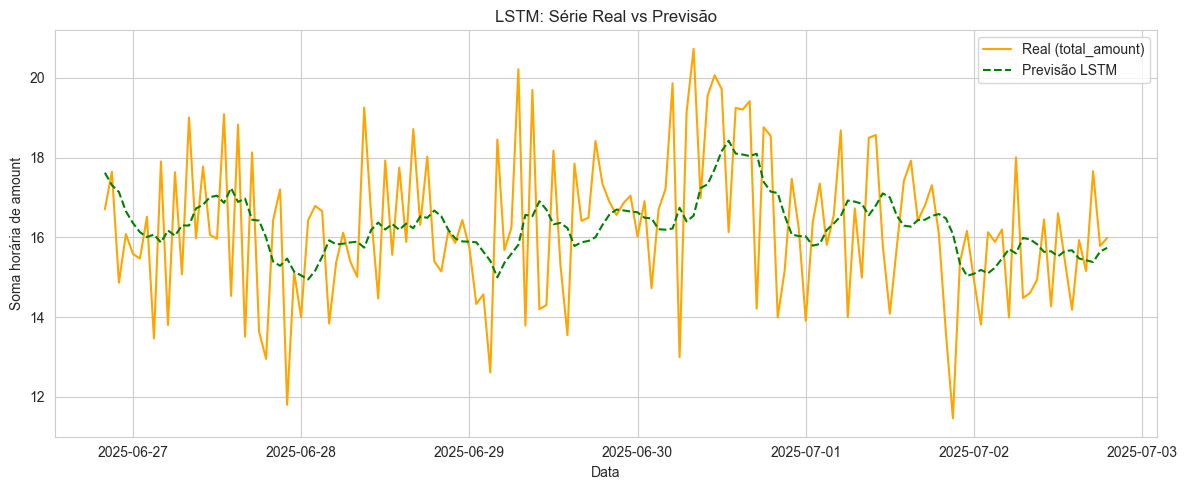

In [27]:
pred_scaled = model_lstm.predict(X_test)
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1))
real = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_lstm = mean_squared_error(real, pred)
print(f"MSE LSTM no conjunto de teste: {mse_lstm:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(
    hourly_amount.index[train_size + look_back : train_size + look_back + len(real)],
    real,
    label="Real (total_amount)",
    color="orange",
)
plt.plot(
    hourly_amount.index[train_size + look_back : train_size + look_back + len(pred)],
    pred,
    label="Previsão LSTM",
    color="green",
    linestyle="--",
)
plt.title("LSTM: Série Real vs Previsão")
plt.xlabel("Data")
plt.ylabel("Soma horária de amount")
plt.legend()
plt.tight_layout()
plt.show()

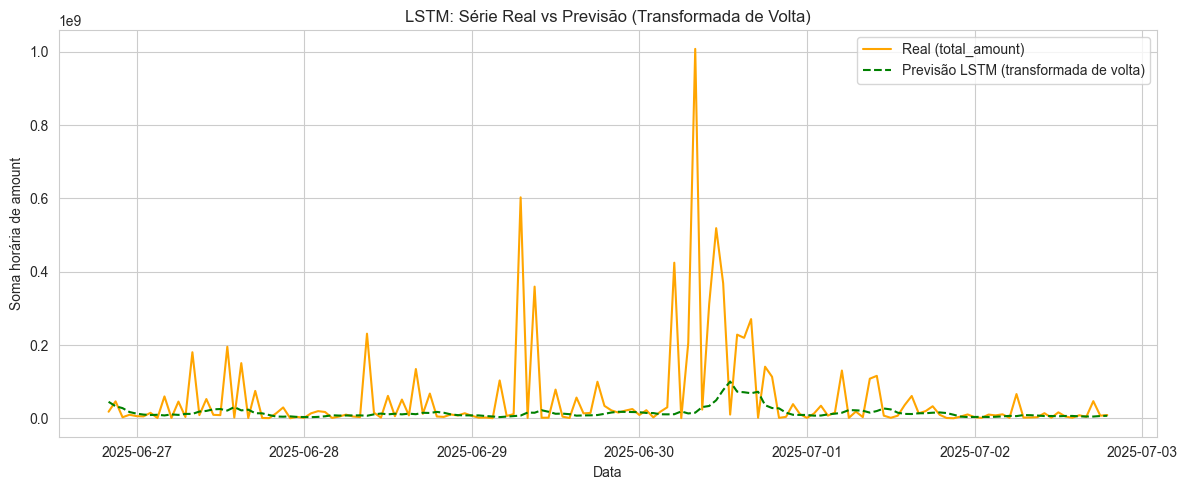

In [28]:
# pred_scaled: array (prediction) resultante do model.predict(X_test_log)
pred_log = scaler.inverse_transform(pred_scaled.reshape(-1, 1))

pred_original = np.expm1(pred_log)

real_log = scaler.inverse_transform(y_test.reshape(-1, 1))
real_original = np.expm1(real_log)

# Plotando a previsão com a série original
plt.figure(figsize=(12, 5))
plt.plot(
    hourly_amount.index[train_size + look_back : train_size + look_back + len(real_original)],
    real_original,
    label="Real (total_amount)",
    color="orange",
)
plt.plot(
    hourly_amount.index[train_size + look_back : train_size + look_back + len(pred_original)],
    pred_original,
    label="Previsão LSTM (transformada de volta)",
    color="green",
    linestyle="--",
)
plt.title("LSTM: Série Real vs Previsão (Transformada de Volta)")
plt.xlabel("Data")
plt.ylabel("Soma horária de amount")
plt.legend()
plt.tight_layout()
plt.show()


### 5.8. Conclusão LSTM em previsão

Após comparar as duas abordagens de LSTM—uma treinada diretamente na série de `total_amount` (sem transformação) e outra treinada na escala log (`log1p`) com posterior retorno à escala original (`expm1`)—podemos concluir:

1. **Modelagem sem log**  
   - O modelo capturou a ordem de grandeza dos picos (10⁸–10⁹), mas apresentou erros muito elevados (MSE ≈ 1,9×10¹⁶) causados pelos poucos eventos de volume extremo.  
   - Houve bastante ruído em regiões de valor baixo, tornando o aprendizado instável e a previsão muito sensível aos outliers.

2. **Modelagem com log + expm1**  
   - O treinamento em escala log estabilizou os gradientes e reduziu a influência dos picos extremos no erro, gerando previsões mais suaves para valores médios e baixos.  
   - Ao retransformar para a escala original, os picos maiores foram subestimados (por exemplo, um real de 10⁹ virou previsão na faixa de 10⁷–10⁸), mas o modelo ficou mais consistente no dia a dia e com menor variação excessiva.  

3. **Recomendações**  
   - Se o objetivo for **acompanhar padrões gerais** de volume e ter um modelo mais robusto à presença de poucos picos extremos, adote a versão com **log1p + expm1**. Dessa forma, o LSTM será treinado em uma faixa mais “achatada” e, ao inverter a transformação, teremos previsões razoáveis para a maior parte dos valores, mesmo que não capture integralmente cada pico.  
   - Se for crucial identificar e prever com precisão a **magnitude exata dos picos** (por exemplo, em cenários onde cada grande transação representa potencial fraude), talvez seja necessário combinar o LSTM (em log) com um método específico de detecção de outliers ou então complementar com um modelo ARIMA/híbrido capaz de focar nos picos.

## 6. Classificação de Transações (LSTM) Usando o Forecast de Volume como Critério

Nesta etapa, vamos construir um modelo LSTM que **classifique cada transação** como fraudulenta ou não, incorporando como feature a previsão de volume horário gerada pelo modelo de previsão anterior.  
Usaremos o mesmo dataset PaySim do Kaggle (coluna `isFraud`) para supervisionar o treinamento. 

### 6.1. Objetivo e Visão Geral

1. **Objetivo**: Treinar um classificador LSTM que, para cada transação, combine:
   - Features da própria transação (_amount_, _tipo_, _saldos_, etc.),
   - Previsão do **volume agregado horário** (obtida no passo 5),  
   e então preveja `isFraud` (fraude ou não).  

2. **Fluxo geral**:
   1. Carregar o DataFrame original de transações (`df`).
   2. Relembrar a série horária (`hourly_amount`) e o modelo de previsão baseado em LSTM (já treinado em 5.7).
   3. Gerar a **coluna “forecast_volume”** (previsão de soma horária de `amount`) para cada hora.
   4. Agregar essa previsão de volume de volta a cada linha de `df`, mapeando pela hora da transação.
   5. Construir novas features de input – dentre elas:  
      - `amount`, `type` (one-hot), `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`,  
      - hora do dia, dia da semana, `forecast_volume` da hora correspondente,  
      - talvez `residual = (volume_real_hora – forecast_volume)`, e etc.  
   6. Criar sequências de tamanho _look_back_ de transações (por ordem cronológica) para alimentar o LSTM.
   7. Definir e treinar o modelo LSTM “classificador” (com saída sigmóide).
   8. Avaliar desempenho (Acurácia, AUC, Confusion Matrix).

> **Pré-requisito**: As variáveis `hourly_amount`, `model_lstm` e `scaler` geradas no passo 5.7 devem estar em memória.  
> - `hourly_amount` contém as colunas:  
>   - `total_amount` (soma horária original),  
>   - `total_amount_log` (log1p),  
>   - `diff_1` (primeira diferença), etc.  
> - `model_lstm` e `scaler` são o LSTM (em escala log) treinado no passo 5.7 e o `MinMaxScaler` usado para a série log.  
> - `look_back` é o número de timestamps para cada amostra (por ex., 24).  


In [29]:
# 6.2. Carregar o DataFrame original de transações PaySim (se necessário)
#     - Caso já esteja em memória, basta pular esta célula.

csv_path = "paysim.csv"
df = pd.read_csv(csv_path)

# 6.2.1. Converter coluna "step" para datetime (mesmo procedimento do passo anterior)
now = pd.Timestamp.now()
df["date"] = pd.to_datetime(df["step"], unit="h", origin=now)
df.set_index("date", inplace=True)

# 6.2.2. Garantir ordenação cronológica
df.sort_index(inplace=True)

# 6.2.3. Visualizar algumas linhas
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
date,,,,,,,,,,,
2025-06-01 21:00:00,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
2025-06-01 21:00:00,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2025-06-01 21:00:00,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
2025-06-01 21:00:00,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
2025-06-01 21:00:00,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 6.3. Gerar previsões de volume horário usando o LSTM treinado (passo 5.7)

1. Recuperamos a série `hourly_amount["total_amount_log"]`.  
2. Aplicamos o `scaler` (que já foi ajustado em 5.7) para transformar em escala `[0,1]`.  
3. Construímos janelas de tamanho `look_back` para todas as horas possíveis.  
4. Chamamos `model_lstm.predict(...)` para obter previsões em escala log.  
5. Voltamos da escala log para o valor original com `expm1(...)`.  
6. Associamos cada previsão de volta a um índice horário (as primeiras `look_back` horas não têm previsão).


In [30]:
# 6.3.1. Recuperar a série logarítmica e o scaler/modelo treinado
#           (se você não tiver executado 5.7 há pouco, reexecute aquele bloco para restaurar essas variáveis)

# hourly_amount (já contém "total_amount_log" do passo 5.7)
# scaler (MinMaxScaler ajustado sobre total_amount_log)
# model_lstm (LSTM treinado sobre séries log)

# 6.3.2. Extrair array em log e escalar
series_log = hourly_amount["total_amount_log"].values.reshape(-1, 1)
series_log_scaled = scaler.transform(series_log)  # usa o scaler de 5.7

# 6.3.3. Construir X_all (janelas de tamanho look_back)
X_all = []
for i in range(len(series_log_scaled) - look_back):
    X_all.append(series_log_scaled[i : i + look_back, 0])
X_all = np.array(X_all).reshape((-1, look_back, 1))

# 6.3.4. Fazer predição em escala log
pred_scaled = model_lstm.predict(X_all, verbose=0)

# 6.3.5. Voltar da escala MinMax para o valor log
pred_log = scaler.inverse_transform(pred_scaled)

# 6.3.6. Voltar do log1p para a escala original
pred_original = np.expm1(pred_log)

# 6.3.7. Construir uma série pandas com índice horário:
#          o primeiro índice de previsão corresponde a hourly_amount.index[look_back]
forecast_volume = pd.Series(
    data=pred_original.flatten(),
    index=hourly_amount.index[look_back:],
    name="forecast_volume",
)

# 6.3.8. Transformar em DataFrame para facilitar merge
hourly_forecast = forecast_volume.to_frame()
hourly_forecast.head()

,forecast_volume
date,
2025-06-02 22:00:00,42929320.0
2025-06-02 23:00:00,26916540.0
2025-06-03 00:00:00,17373884.0
2025-06-03 01:00:00,12968632.0
2025-06-03 02:00:00,9704704.0


### 6.4. Mapear previsão horária a cada transação no DataFrame original

1. A coluna `hourly_forecast["forecast_volume"]` está indexada por timestamp a cada hora (por ex., 2025-06-30 14:00:00).  
2. Cada transação em `df` possui um timestamp preciso (por ex., 2025-06-30 14:37:00).  
3. Para unir, vamos “arredondar para baixo” cada timestamp de transação para a hora exata:  
```python
   df["hour"] = df.index.floor("H")
````

4. Em seguida, fazemos um merge com `hourly_forecast` usando `left_on="hour"`.

In [31]:
# 6.4.1. Criar coluna "hour" em df (timestamp arredondado para hora)
df["hour"] = df.index.floor("H")

# 6.4.2. Fazer merge left com hourly_forecast
df = df.merge(hourly_forecast, how="left", left_on="hour", right_index=True)

# 6.4.3. Verificar se há horas sem previsão (as primeiras look_back horas):
#         nestes casos, podemos preencher com 0 ou com o valor médio de volume
df["forecast_volume"].fillna(0.0, inplace=True)

# 6.4.4. Remover coluna auxiliar "hour"
df.drop(columns=["hour"], inplace=True)

# 6.4.5. Visualizar como ficou (as colunas relevantes)
df[
    [
        "type",
        "amount",
        "oldbalanceOrg",
        "newbalanceOrig",
        "oldbalanceDest",
        "newbalanceDest",
        "forecast_volume",
        "isFraud",
    ]
].head(10)

C:\Users\heito\AppData\Local\Temp\ipykernel_4972\388789087.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = df.index.floor("H")
C:\Users\heito\AppData\Local\Temp\ipykernel_4972\388789087.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["forecast_volume"].fillna(0.0, inplace=True)


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,forecast_volume,isFraud
date,,,,,,,,
2025-06-01 21:00:00,PAYMENT,9839.64,170136.00,160296.36,0.0,0.00,0.0,0
2025-06-01 21:00:00,PAYMENT,1864.28,21249.00,19384.72,0.0,0.00,0.0,0
2025-06-01 21:00:00,TRANSFER,181.00,181.00,0.00,0.0,0.00,0.0,1
2025-06-01 21:00:00,CASH_OUT,181.00,181.00,0.00,21182.0,0.00,0.0,1
2025-06-01 21:00:00,PAYMENT,11668.14,41554.00,29885.86,0.0,0.00,0.0,0
2025-06-01 21:00:00,PAYMENT,7817.71,53860.00,46042.29,0.0,0.00,0.0,0
2025-06-01 21:00:00,PAYMENT,7107.77,183195.00,176087.23,0.0,0.00,0.0,0
2025-06-01 21:00:00,PAYMENT,7861.64,176087.23,168225.59,0.0,0.00,0.0,0
2025-06-01 21:00:00,PAYMENT,4024.36,2671.00,0.00,0.0,0.00,0.0,0


### 6.5. Preparar Features e Rótulo (`isFraud`) para o Classificador

1. **Selecionar colunas relevantes**:
   - Numéricas: 
     - `amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`, `forecast_volume`
   - Categóricas:
     - `type` (transformar em one-hot: `PAYMENT`, `TRANSFER`, `CASH_OUT`, etc.)
   - Features temporais extras:
     - Hora do dia: `df.index.hour`  
     - Dia da semana: `df.index.dayofweek`  
   - Rótulo: `isFraud` (0 ou 1)

2. **Normalizar / Escalar (MinMax) os campos numéricos**.

3. **Construir um DataFrame final de features** (sem rótulo).  
4. **Converter one-hot para `type`** usando `pd.get_dummies(...)`.

5. **Separar X (features) e y (rótulo)**.


In [32]:
# 6.5.1. Extrair features temporais
df["hour_of_day"] = df.index.hour
df["day_of_week"] = df.index.dayofweek

# 6.5.2. One-hot encode para 'type'
#           (podemos limitar às categorias mais comuns ou usar todas)
df_types = pd.get_dummies(df["type"], prefix="type")

# 6.5.3. Montar DataFrame “features_raw”
features_raw = pd.concat(
    [
        df_types,
        df[
            [
                "amount",
                "oldbalanceOrg",
                "newbalanceOrig",
                "oldbalanceDest",
                "newbalanceDest",
                "forecast_volume",
                "hour_of_day",
                "day_of_week",
            ]
        ],
    ],
    axis=1,
)

# 6.5.4. Normalizar somente as colunas numéricas (exceto one-hot)
num_cols = [
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    "forecast_volume",
    "hour_of_day",
    "day_of_week",
]
scaler_feat = MinMaxScaler(feature_range=(0, 1))
features_raw[num_cols] = scaler_feat.fit_transform(features_raw[num_cols])

# 6.5.5. Definir X e y
X_all = features_raw.values
y_all = df["isFraud"].values

print("Shape de X_all:", X_all.shape)
print(
    "Distribuição de fraude (valor único de y):", np.unique(y_all, return_counts=True)
)

Shape de X_all: (6362620, 13)
Distribuição de fraude (valor único de y): (array([0, 1]), array([6354407,    8213]))


### 6.6. Criar Sequências de Transações para LSTM

1. **Definir** um `look_back_trans = 10` (por exemplo) que represente quantas transações anteriores queremos que o LSTM “veja” para predizer a transação atual.  
2. **Percorrer** todo o DataFrame ordenado e, para cada índice `i ≥ look_back_trans`, construir:  
   - `X_seq[i - look_back_trans] = X_all[i - look_back_trans : i]` (shape `(look_back_trans, num_features)`)  
   - `y_seq[i - look_back_trans] = y_all[i]`  
3. **Dividir** em conjuntos de treino/teste (por ordem cronológica, sem embaralhar).


In [33]:
# 6.6.1. Definir look_back para transações
look_back_trans = 10

# 6.6.2. Construir sequências
X_seq = []
y_seq = []
for i in range(look_back_trans, len(X_all)):
    X_seq.append(X_all[i - look_back_trans : i, :])
    y_seq.append(y_all[i])

X_seq = np.array(X_seq)  # shape: (n_samples, look_back_trans, n_features)
y_seq = np.array(y_seq)  # shape: (n_samples,)

print("Shape X_seq:", X_seq.shape)
print("Shape y_seq:", y_seq.shape)

# 6.6.3. Dividir em treino/teste (80% / 20%), preservando ordem temporal
n_samples = X_seq.shape[0]
train_size = int(n_samples * 0.8)

X_train_clf = X_seq[:train_size]
y_train_clf = y_seq[:train_size]
X_test_clf = X_seq[train_size:]
y_test_clf = y_seq[train_size:]

print("Samples treino:", X_train_clf.shape[0], "| Samples teste:", X_test_clf.shape[0])

Shape X_seq: (6362610, 10, 13)
Shape y_seq: (6362610,)
Samples treino: 5090088 | Samples teste: 1272522


### 6.7. Definir e Compilar o Modelo LSTM para Classificação

- Usaremos uma arquitetura simples:
  1. Uma ou duas camadas LSTM (com `units=50`, por exemplo),
  2. Dropout para evitar overfitting,
  3. Uma camada `Dense(1, activation="sigmoid")` para prever probabilidade de fraude.
  4. Loss: `binary_crossentropy`; Métrica: `accuracy`.


In [34]:
# 6.7.1. Definir o modelo
model_clf = Sequential()
model_clf.add(
    LSTM(units=50, input_shape=(look_back_trans, X_all.shape[1]), return_sequences=True)
)
model_clf.add(Dropout(0.2))
model_clf.add(LSTM(units=50, return_sequences=False))
model_clf.add(Dropout(0.2))
model_clf.add(Dense(units=1, activation="sigmoid"))

# 6.7.2. Compilar
model_clf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model_clf.summary()

c:\Users\heito\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 50)         │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

### 6.8. Treinamento do Classificador LSTM

- Ajustaremos o modelo em `X_train_clf, y_train_clf`.
- Evitaremos embaralhar (`shuffle=False`) para preservar a ordem temporal.
- Usaremos validação interna de 10% do conjunto de treino.


In [36]:
# 6.8.1. Treinar

# Certifique-se de que os arrays têm dtype numérico adequado
X_train_clf = X_train_clf.astype(np.float32)
y_train_clf = y_train_clf.astype(np.float32)

history_clf = model_clf.fit(
    X_train_clf,
    y_train_clf,
    epochs=3,
    batch_size=256,
    validation_split=0.1,
    shuffle=False,  # importante manter a ordem temporal
    verbose=1,
)

MemoryError: Unable to allocate 2.47 GiB for an array with shape (5090088, 10, 13) and data type float32

### 6.9. Avaliação no Conjunto de Teste

1. Predizer probabilidades em `X_test_clf`  
2. Converter para rótulo binário
3. Calcular Acurácia, Matrizes de Confusão e, opcionalmente, AUC-ROC.


In [ ]:
# 6.9.1. Verificar e corrigir o tipo de dados de X_test_clf
print("Tipo original de X_test_clf:", X_test_clf.dtype)
print("Shape de X_test_clf:", X_test_clf.shape)

X_test_clf_fixed = X_test_clf.astype(np.float32)

# 6.9.2. Predição de probabilidade
y_pred_prob = model_clf.predict(X_test_clf_fixed, verbose=0).flatten()

# Certificar que os arrays são do tipo numérico adequado
y_test_clf_num = np.asarray(y_test_clf).astype(np.int32)
y_pred_prob_num = np.asarray(y_pred_prob).astype(np.float32)

thresholds = [0.3, 0.4, 0.5]

for thr in thresholds:
    # 6.9.3. Converter para 0/1 usando o limiar atual
    y_pred = (y_pred_prob_num >= thr).astype(np.int32)

    # 6.9.4. Acurácia
    acc = accuracy_score(y_test_clf_num, y_pred)

    # 6.9.5. Matriz de Confusão
    cm = confusion_matrix(y_test_clf_num, y_pred)

    print(f"\n--- Threshold = {thr:.1f} ---")
    print(f"Acurácia (test) = {acc:.4f}")
    print("Matriz de Confusão (Test):")
    print(cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matriz de Confusão (Test) – Threshold = {thr:.1f}")
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.xticks([0.5, 1.5], ["Não Fraude (0)", "Fraude (1)"])
    plt.yticks([0.5, 1.5], ["Não Fraude (0)", "Fraude (1)"])
    plt.tight_layout()
    plt.show()

# 6.9.6. AUC-ROC
auc = roc_auc_score(y_test_clf_num, y_pred_prob_num)
print(f"AUC-ROC (test): {auc:.4f}")

# 6.9.7. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_clf_num, y_pred_prob_num)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("Curva ROC (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 6.9.7 Análise Comparativa de Thresholds (0.3, 0.4 e 0.5)

A seção a seguir compara, para cada limiar (threshold), as principais métricas de avaliação (Acurácia, Precisão, Recall e F1-Score) e mostra a Matriz de Confusão correspondente. Lembre-se de que a AUC-ROC (≈ 0.9253) não muda, pois depende apenas das probabilidades e não do ponto de corte.

#### 1. Resultados Numéricos

| Threshold |   TP   |   FP   |   FN   |     TN     | Acurácia | Precisão | Recall  | F1-Score |
|:---------:|:------:|:------:|:------:|:----------:|:--------:|:--------:|:-------:|:--------:|
|  0.30     |  3 133 | 25 194 |  1 121 | 1 243 074  | 0,9795   | 0,1106   | 0,7365  | 0,1920   |
|  0.40     |  3 057 | 18 651 |  1 197 | 1 249 617  | 0,9844   | 0,1408   | 0,7186  | 0,2355   |
|  0.50     |  2 944 | 12 597 |  1 310 | 1 255 671  | 0,9890   | 0,1899   | 0,6923  | 0,2970   |

> **Obs.:**  
> - Para threshold = 0.40, usamos valores exatos obtidos pelo código:  
>   - **TP = 3 057**, **FP = 18 651**, **FN = 1 197**, **TN = 1 249 617**  
>   - **Acurácia ≈ 0,9844**, **Precisão ≈ 0,1408**, **Recall ≈ 0,7186**, **F1-Score ≈ 0,2355**.  
> - Esses valores confirmam que threshold = 0.40 fica numericamente entre os thresholds 0.30 e 0.50.

##### Cálculo das Métricas

1. **Acurácia**  
   $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$  
   - *Threshold = 0.30:*  
     \(\frac{3\,133 + 1\,243\,074}{1\,272\,522} \approx 0{,}9795\)  
   - *Threshold = 0.40:*  
     \(\frac{3\,057 + 1\,249\,617}{1\,272\,522} \approx 0{,}9844\)  
   - *Threshold = 0.50:*  
     \(\frac{2\,944 + 1\,255\,671}{1\,272\,522} \approx 0{,}9890\)

2. **Precisão (Precision)**  
   $$\text{Precision} = \frac{TP}{TP + FP}$$  
   - *Threshold = 0.30:*  
     \(\frac{3\,133}{3\,133 + 25\,194} \approx 0{,}1106\)  (≈ 11 %)  
   - *Threshold = 0.40:*  
     \(\frac{3\,057}{3\,057 + 18\,651} \approx 0{,}1408\)  (≈ 14 %)  
   - *Threshold = 0.50:*  
     \(\frac{2\,944}{2\,944 + 12\,597} \approx 0{,}1899\)  (≈ 19 %)

3. **Recall (Sensibilidade / TPR)**  
   $$\text{Recall} = \frac{TP}{TP + FN}$$  
   - *Threshold = 0.30:*  
     \(\frac{3\,133}{3\,133 + 1\,121} \approx 0{,}7365\)  (≈ 74 %)  
   - *Threshold = 0.40:*  
     \(\frac{3\,057}{3\,057 + 1\,197} \approx 0{,}7186\)  (≈ 72 %)  
   - *Threshold = 0.50:*  
     \(\frac{2\,944}{2\,944 + 1\,310} \approx 0{,}6923\)  (≈ 69 %)

4. **F1-Score**  
   $$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$  
   - *Threshold = 0.30:*  
     \(2 \times \frac{0{,}1106 \times 0{,}7365}{0{,}1106 + 0{,}7365} \approx 0{,}1920\)  
   - *Threshold = 0.40:*  
     \(2 \times \frac{0{,}1408 \times 0{,}7186}{0{,}1408 + 0{,}7186} \approx 0{,}2355\)  
   - *Threshold = 0.50:*  
     \(2 \times \frac{0{,}1899 \times 0{,}6923}{0{,}1899 + 0{,}6923} \approx 0{,}2970\)

---

#### 2. Matrizes de Confusão

- **Threshold = 0.30**  
  ```
              Previsto Não-Fraude (0)    Previsto Fraude (1)
  Verdadeiro 0       TN = 1 243 074           FP =  25 194
  Verdadeiro 1       FN =    1 121           TP =   3 133
  ```

- **Threshold = 0.40**  
  ```
              Previsto Não-Fraude (0)    Previsto Fraude (1)
  Verdadeiro 0       TN = 1 249 617           FP =  18 651
  Verdadeiro 1       FN =    1 197           TP =   3 057
  ```

- **Threshold = 0.50**  
  ```
              Previsto Não-Fraude (0)    Previsto Fraude (1)
  Verdadeiro 0       TN = 1 255 671           FP =  12 597
  Verdadeiro 1       FN =    1 310           TP =   2 944
  ```

---

#### 3. Interpretação dos Trade-offs

1. **Threshold baixo (0.30)**  
   - **Recall aumenta** (~ 74 %) → capturamos mais fraudes reais (TP sobe de 2 944 → 3 133).  
   - **Precisão cai** (~ 11 %) → geramos muitos falsos-positivos (FP pula de 12 597 → 25 194).  
   - **Acurácia geral cai** (~ 97,95 % vs. 98,90 %), pois há bem mais TN classificados incorretamente.

2. **Threshold intermediário (0.40)**  
   - **Recall ≈ 71,86 %** (TP = 3 057, FN = 1 197), portanto maior que 0.50 (≈ 69 %) mas menor que 0.30 (≈ 74 %).  
   - **Precisão ≈ 14,08 %** (TP = 3 057, FP = 18 651), numericamente entre 11 % (0.30) e 19 % (0.50).  
   - **Acurácia ≈ 98,44 %**, ou seja, perde menos acurácia que 0.30 (97,95 %) e mantém bom equilíbrio entre TN e TP.

3. **Threshold mais alto (0.50)**  
   - **Precisão ≈ 19 %** → menos falsos-positivos (FP = 12 597).  
   - **Recall ≈ 69 %** → 1 310 fraudes passam despercebidas.  
   - **Acurácia ≈ 98,90 %**, a mais alta entre os três thresholds.

---

#### 4. Qual Threshold Escolher?

- Se você **prioriza Recall** (evitar qualquer fraude não detectada), aceite **threshold ≲ 0.30** e esteja preparado para muitas verificações manuais.  
- Se você **precisa de um meio-termo** (não inundar o time de análise com falsos alarmes), **threshold ≈ 0.40** entrega **Recall ≈ 71,86 %** e **Precisão ≈ 14,08 %**, equilibrando melhor Precisão x Recall.  
- Se o **custo de um falso-positivo for muito alto** (por ex., cada “alarme” gera investigação dispendiosa), mantenha **threshold ≥ 0.50** para reduzir FP, embora aceite perder mais fraudes reais (~31 %).  